In [1]:
import json
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np


In [2]:
# Function to load JSON features
def load_features(features_dir, dataset_label):
    features_list = []
    labels = []

    for file in os.listdir(features_dir):
        if file.endswith('.json'):
            with open(os.path.join(features_dir, file), 'r') as f:
                features = json.load(f)
                features_list.append(features)
                labels.append(dataset_label)

    # skip all '.cov' and '.icov' features and some metadata
    for i in range(len(features_list)):
        features_list[i].pop('lowlevel.gfcc.cov', None)
        features_list[i].pop('lowlevel.gfcc.icov', None)
        features_list[i].pop('lowlevel.mfcc.cov', None)
        features_list[i].pop('lowlevel.mfcc.icov', None)
        features_list[i].pop('metadata.tags.file_name', None)
        features_list[i].pop('metadata.audio_properties.md5_encoded', None)
        features_list[i].pop('metadata.version.essentia', None)
        features_list[i].pop('metadata.version.essentia_git_sha', None)
        features_list[i].pop('metadata.version.extractor', None)
        features_list[i].pop('metadata.tags.artist', None)
        features_list[i].pop('metadata.tags.title', None)
        features_list[i].pop('metadata.tags.genre', None)
        features_list[i].pop('metadata.tags.encoding', None)
        
    return features_list, labels

# Function to convert list of dicts to a DataFrame
def features_to_dataframe(features_list):
    df = pd.DataFrame(features_list)
    # if any feature is not scalar, expand it to multiple columns with the name {column_name}_{index}
    for column in df.columns:
        if not df[column].apply(lambda x: np.isscalar(x)).all():
            expanded = df[column].apply(pd.Series)
            expanded.columns = [f"{column}_{subcolumn}" for subcolumn in expanded.columns]
            df = pd.concat([df, expanded], axis=1)
            df = df.drop(column, axis=1)

    return df

In [3]:
# if '/home/laura/aimir/mess/essentia_features.csv' exists, load it
if os.path.exists('/home/laura/aimir/mess/essentia_features.csv'):
    df_features = pd.read_csv('/home/laura/aimir/mess/essentia_features.csv')
    df_labels = pd.read_csv('/home/laura/aimir/mess/essentia_labels.csv', header=None, names=['label'])

else:
    # Load features and labels for each dataset
    features_suno, labels_suno = load_features('/home/laura/aimir/suno/essentia_features', 0)
    features_udio, labels_udio = load_features('/home/laura/aimir/udio/essentia_features', 1)
    features_lastfm, labels_lastfm = load_features('/home/laura/aimir/lastfm/essentia_features', 2)

    # Combine features and labels
    features_combined = features_suno + features_udio + features_lastfm
    labels_combined = labels_suno + labels_udio + labels_lastfm

    # Convert to DataFrame
    df_features = features_to_dataframe(features_combined)
    df_labels = pd.Series(labels_combined, name='label')

    # Handle missing values (if any)
    df_features = df_features.fillna(0)

    # handle string values in columns
    for column in df_features.columns:
        if df_features[column].dtype == 'object':
            # turn them into categorical values
            df_features[column] = df_features[column].astype('category').cat.codes

In [20]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_features['label'], test_size=0.2, random_state=42, stratify=df_features['label'])

# encode labels
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'udio'

In [5]:
# Predict and evaluate the model
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=['suno', 'udio', 'lastfm'], digits=3))

# Get feature importance
feature_importance = pd.Series(clf.feature_importances_, index=df_features.columns)
important_features = feature_importance.sort_values(ascending=False)

# Display the most important features
print("Top 10 Important Features:")
print(important_features.head(10))

Accuracy: 0.9703333333333334
              precision    recall  f1-score   support

        suno      0.970     0.974     0.972      2000
        udio      0.964     0.964     0.964      2000
      lastfm      0.977     0.974     0.975      2000

    accuracy                          0.970      6000
   macro avg      0.970     0.970     0.970      6000
weighted avg      0.970     0.970     0.970      6000

Top 10 Important Features:
metadata.audio_properties.bit_rate       0.043149
metadata.audio_properties.sample_rate    0.027265
lowlevel.erbbands.stdev_38               0.017088
lowlevel.melbands_skewness.stdev         0.015960
lowlevel.melbands_kurtosis.stdev         0.014628
lowlevel.melbands_kurtosis.mean          0.013437
lowlevel.barkbands_kurtosis.mean         0.013036
lowlevel.barkbands_kurtosis.stdev        0.012716
lowlevel.erbbands.stdev_39               0.012252
lowlevel.melbands_skewness.mean          0.011631
dtype: float64


Feature: metadata.audio_properties.bit_rate
                 mean           std
label                              
lastfm  219836.996199  28591.332404
suno    191983.198320   2183.728799
udio    320000.000000      0.000000
Feature: metadata.audio_properties.sample_rate
                mean         std
label                           
lastfm  44100.000000    0.000000
suno    47993.894389  284.619354
udio    48000.000000    0.000000
Feature: lowlevel.erbbands.stdev_38
            mean       std
label                     
lastfm  0.000677  0.009307
suno    0.006748  0.011825
udio    0.011547  0.033355
Feature: lowlevel.melbands_skewness.stdev
             mean        std
label                       
lastfm   2.352611  17.180221
suno    14.065788  11.269301
udio     2.232384   1.196848
Feature: lowlevel.melbands_kurtosis.stdev
               mean            std
label                             
lastfm  1427.702229  124243.498064
suno    2963.874686    3474.180130
udio      50.975833     

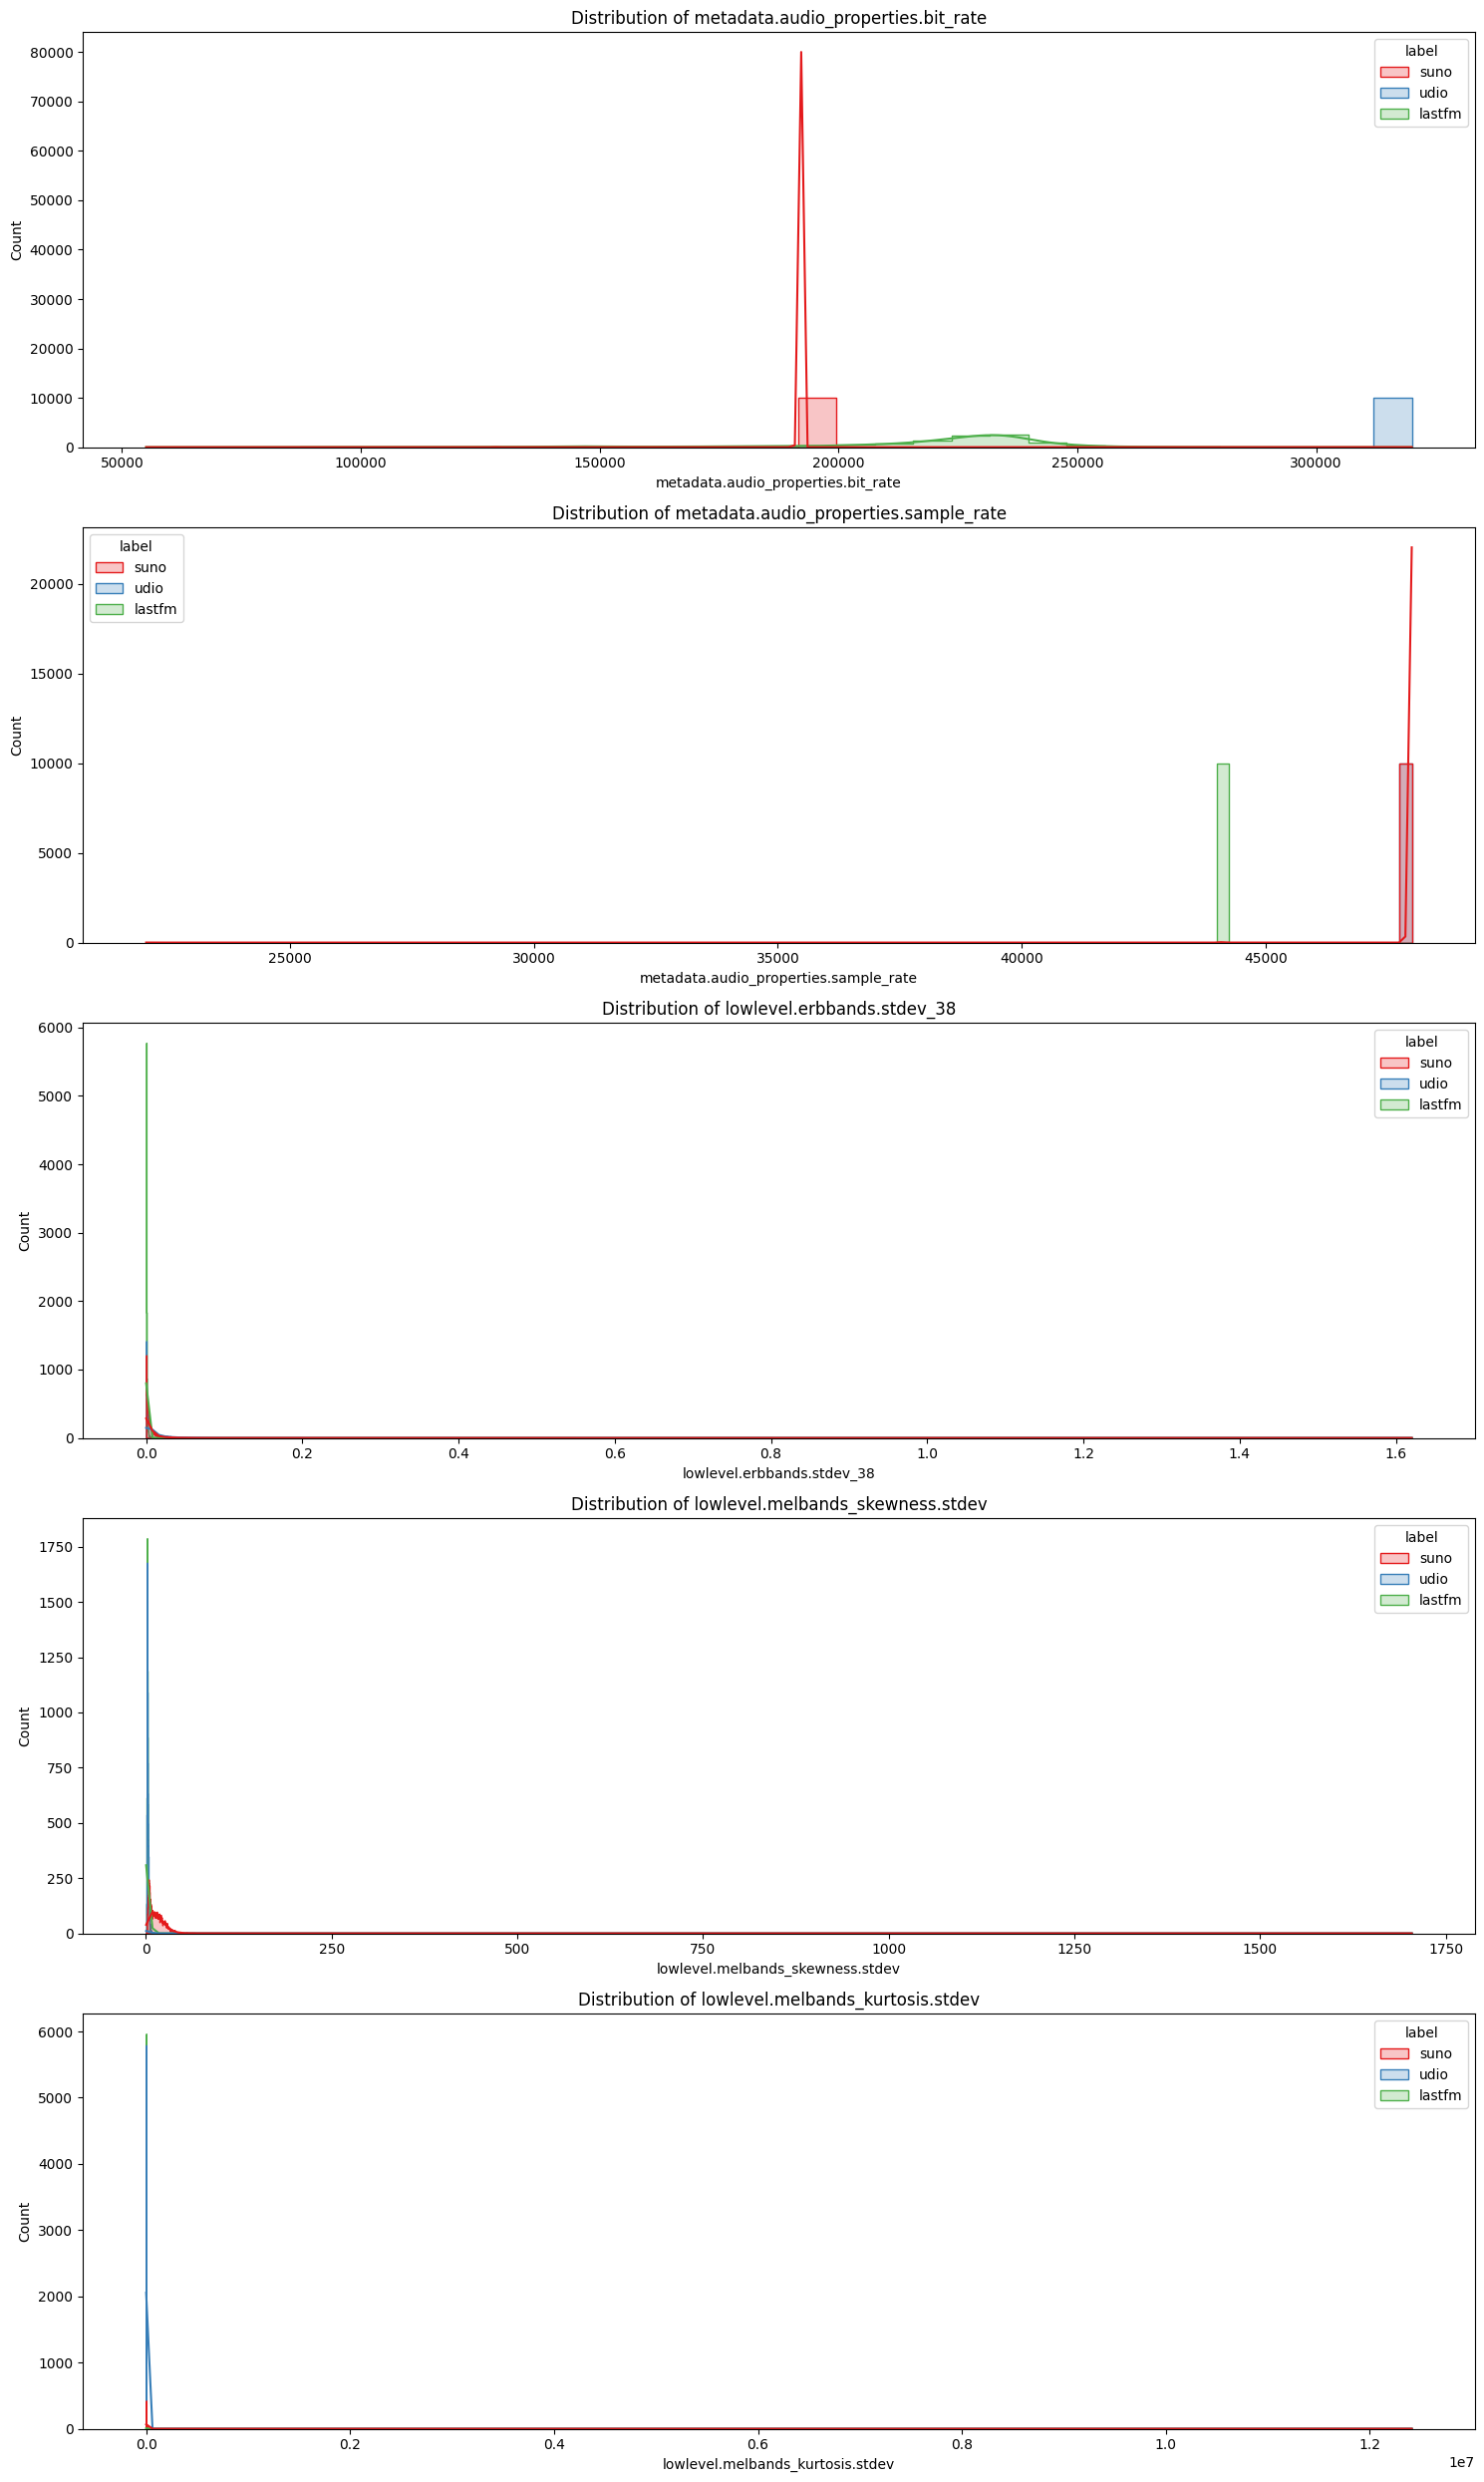

Feature: lowlevel.average_loudness
            mean       std
label                     
lastfm  0.793065  0.232101
suno    0.746698  0.231995
udio    0.789193  0.229940
Feature: lowlevel.spectral_centroid.mean
               mean         std
label                          
lastfm  1475.670629  633.352898
suno    1142.599548  419.351345
udio    1333.484687  473.924948
Feature: rhythm.bpm
              mean        std
label                        
lastfm  124.189108  24.985475
suno    121.766195  27.166135
udio    124.234556  23.676800
Feature: lowlevel.silence_rate_60dB.mean
            mean       std
label                     
lastfm  0.110467  0.099855
suno    0.132608  0.097711
udio    0.103121  0.100898
Feature: lowlevel.pitch_salience.mean
            mean       std
label                     
lastfm  0.531502  0.057998
suno    0.407968  0.068186
udio    0.525802  0.060989
Feature: lowlevel.dynamic_complexity
            mean       std
label                     
lastfm  3.930576  1

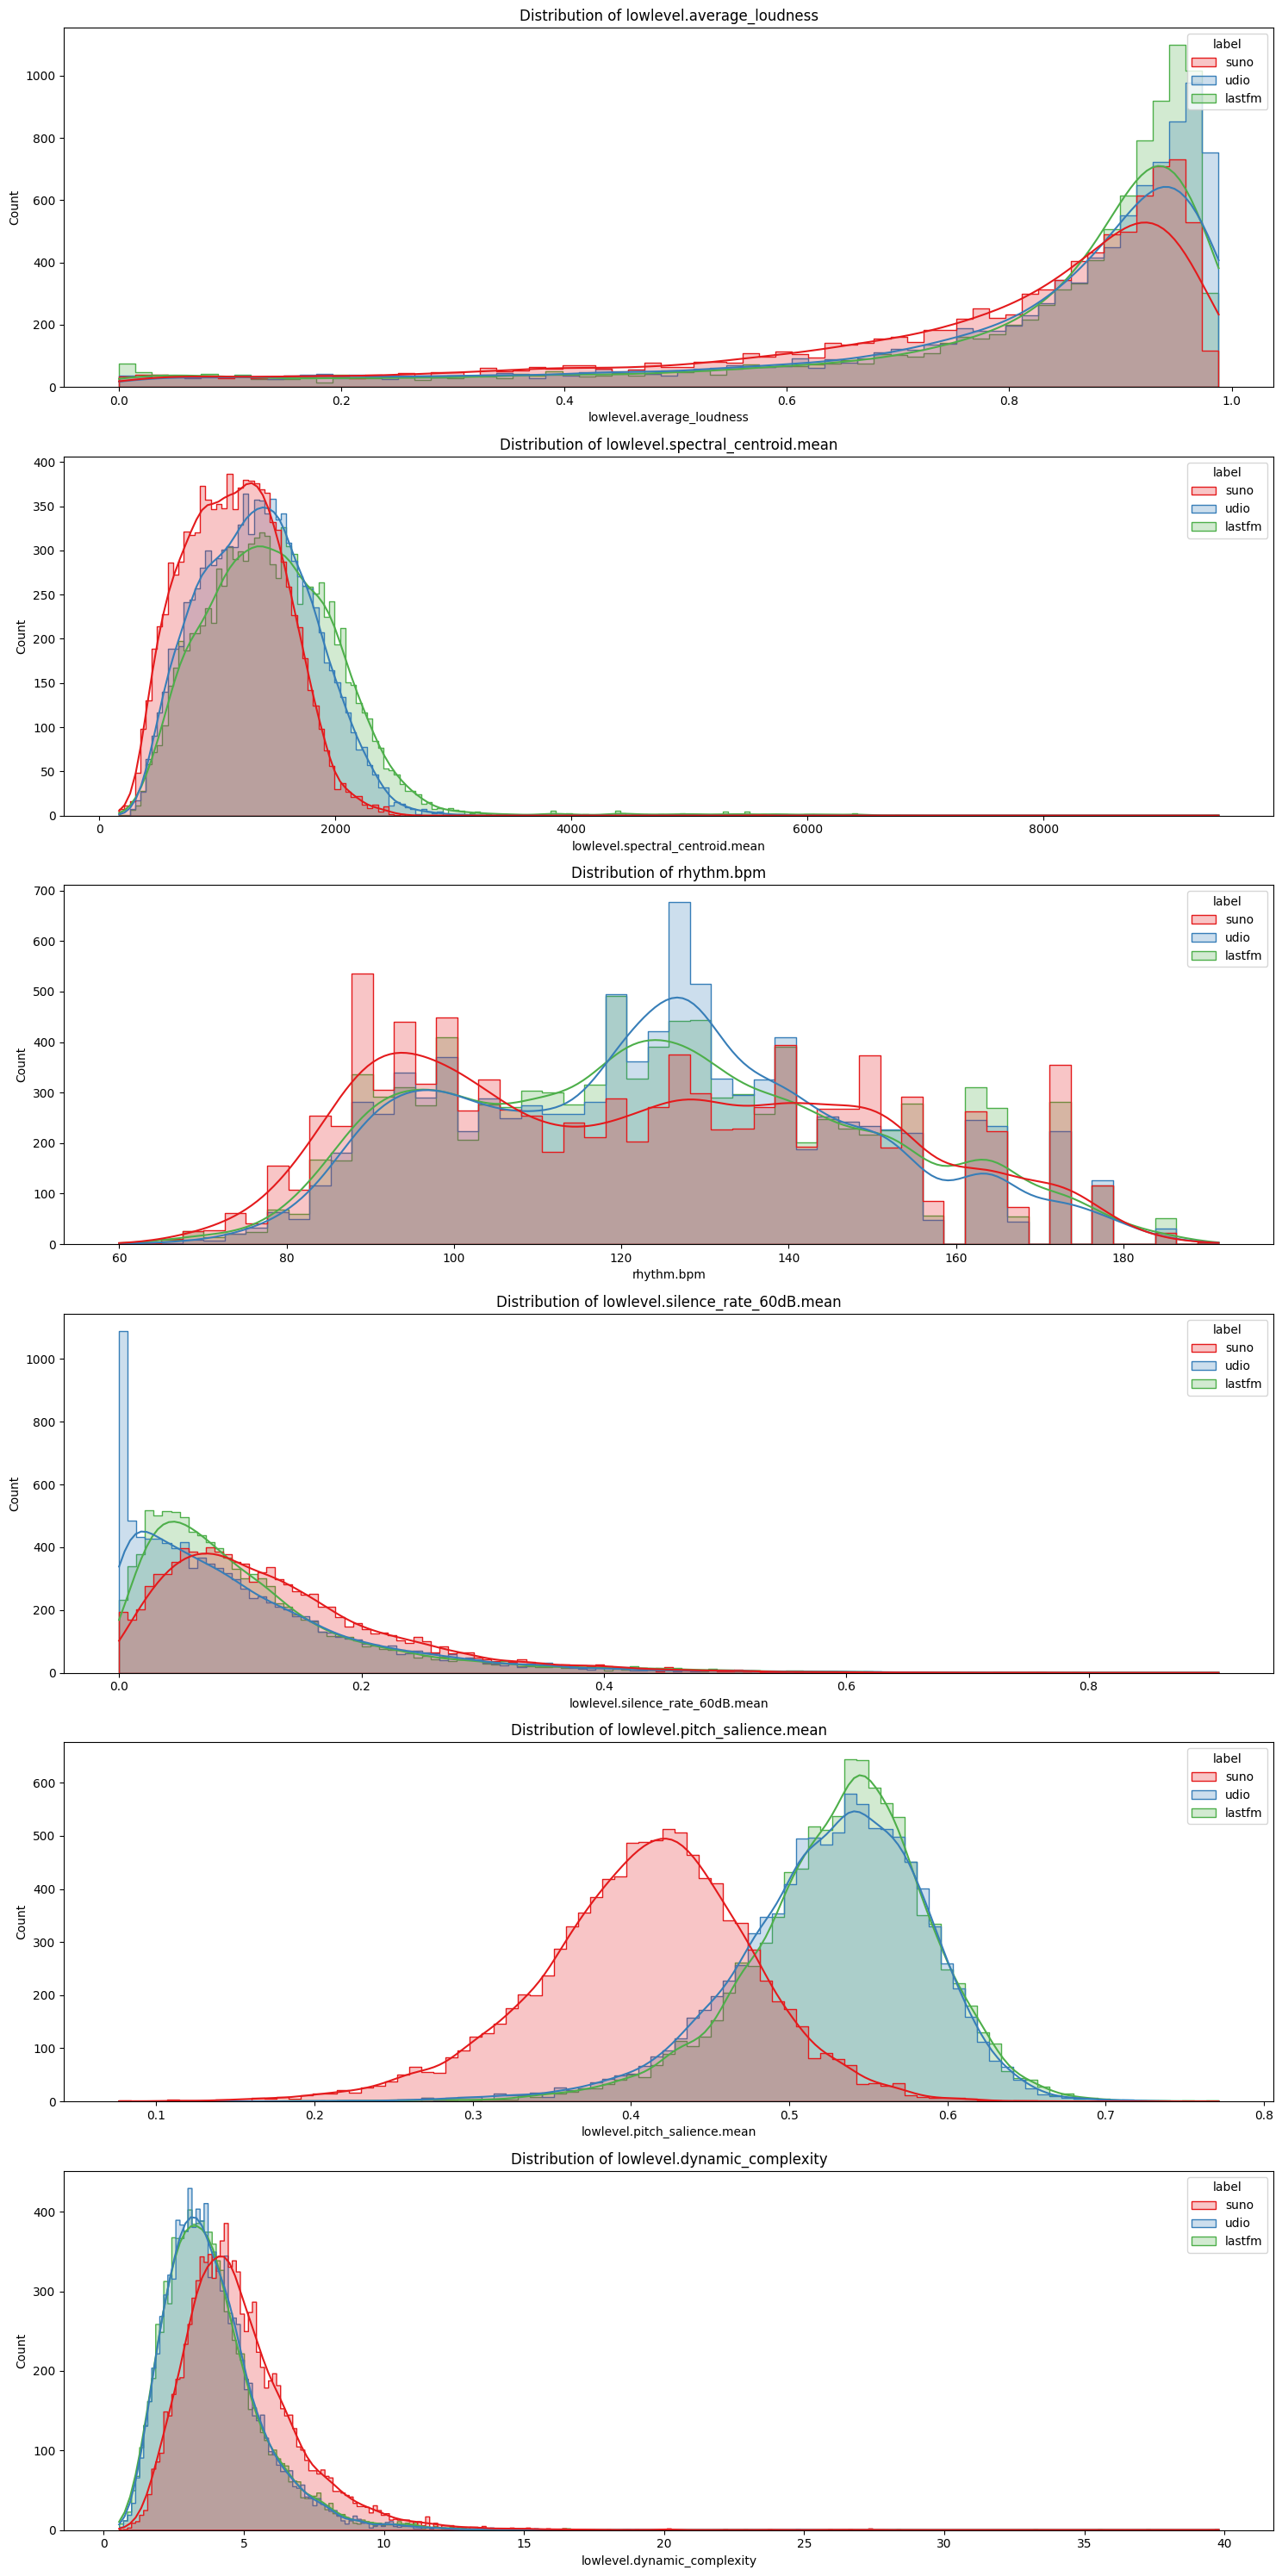

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting distributions for the top N important features
def plot_feature_distributions(features_df, labels_df, important_features, top_n=10):
    if isinstance(important_features, list):
        top_features = important_features[:top_n]
    else:
        top_features = important_features.head(top_n).index.tolist()
    
    # Add the label to the features DataFrame
    features_df['label'] = labels_df
    
    # print mean and std for each feature for each label in a nice dataframe table
    for feature in top_features:
        print(f"Feature: {feature}")
        print(features_df.groupby('label')[feature].agg(['mean', 'std']))

        
    # Set up the plotting environment
    plt.figure(figsize=(15, top_n * 5))
    
    for i, feature in enumerate(top_features):
        plt.subplot(top_n, 1, i + 1)
        sns.histplot(data=features_df, x=feature, hue='label', kde=True, element='step', palette='Set1')
        plt.title(f'Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()


# Call the function to plot distributions for the top 10 features
# turn df_labels into the strings
df_labels = df_labels.replace({0: 'suno', 1: 'udio', 2: 'lastfm'})
plot_feature_distributions(df_features, df_labels, important_features, top_n=5)
features_to_plot = ['lowlevel.average_loudness', 'lowlevel.spectral_centroid.mean', 'rhythm.bpm', 'lowlevel.silence_rate_60dB.mean', 'lowlevel.pitch_salience.mean', 'lowlevel.dynamic_complexity', 'lowlevel.melbands_skewness.mean']
plot_feature_distributions(df_features, df_labels, features_to_plot, top_n=len(features_to_plot))


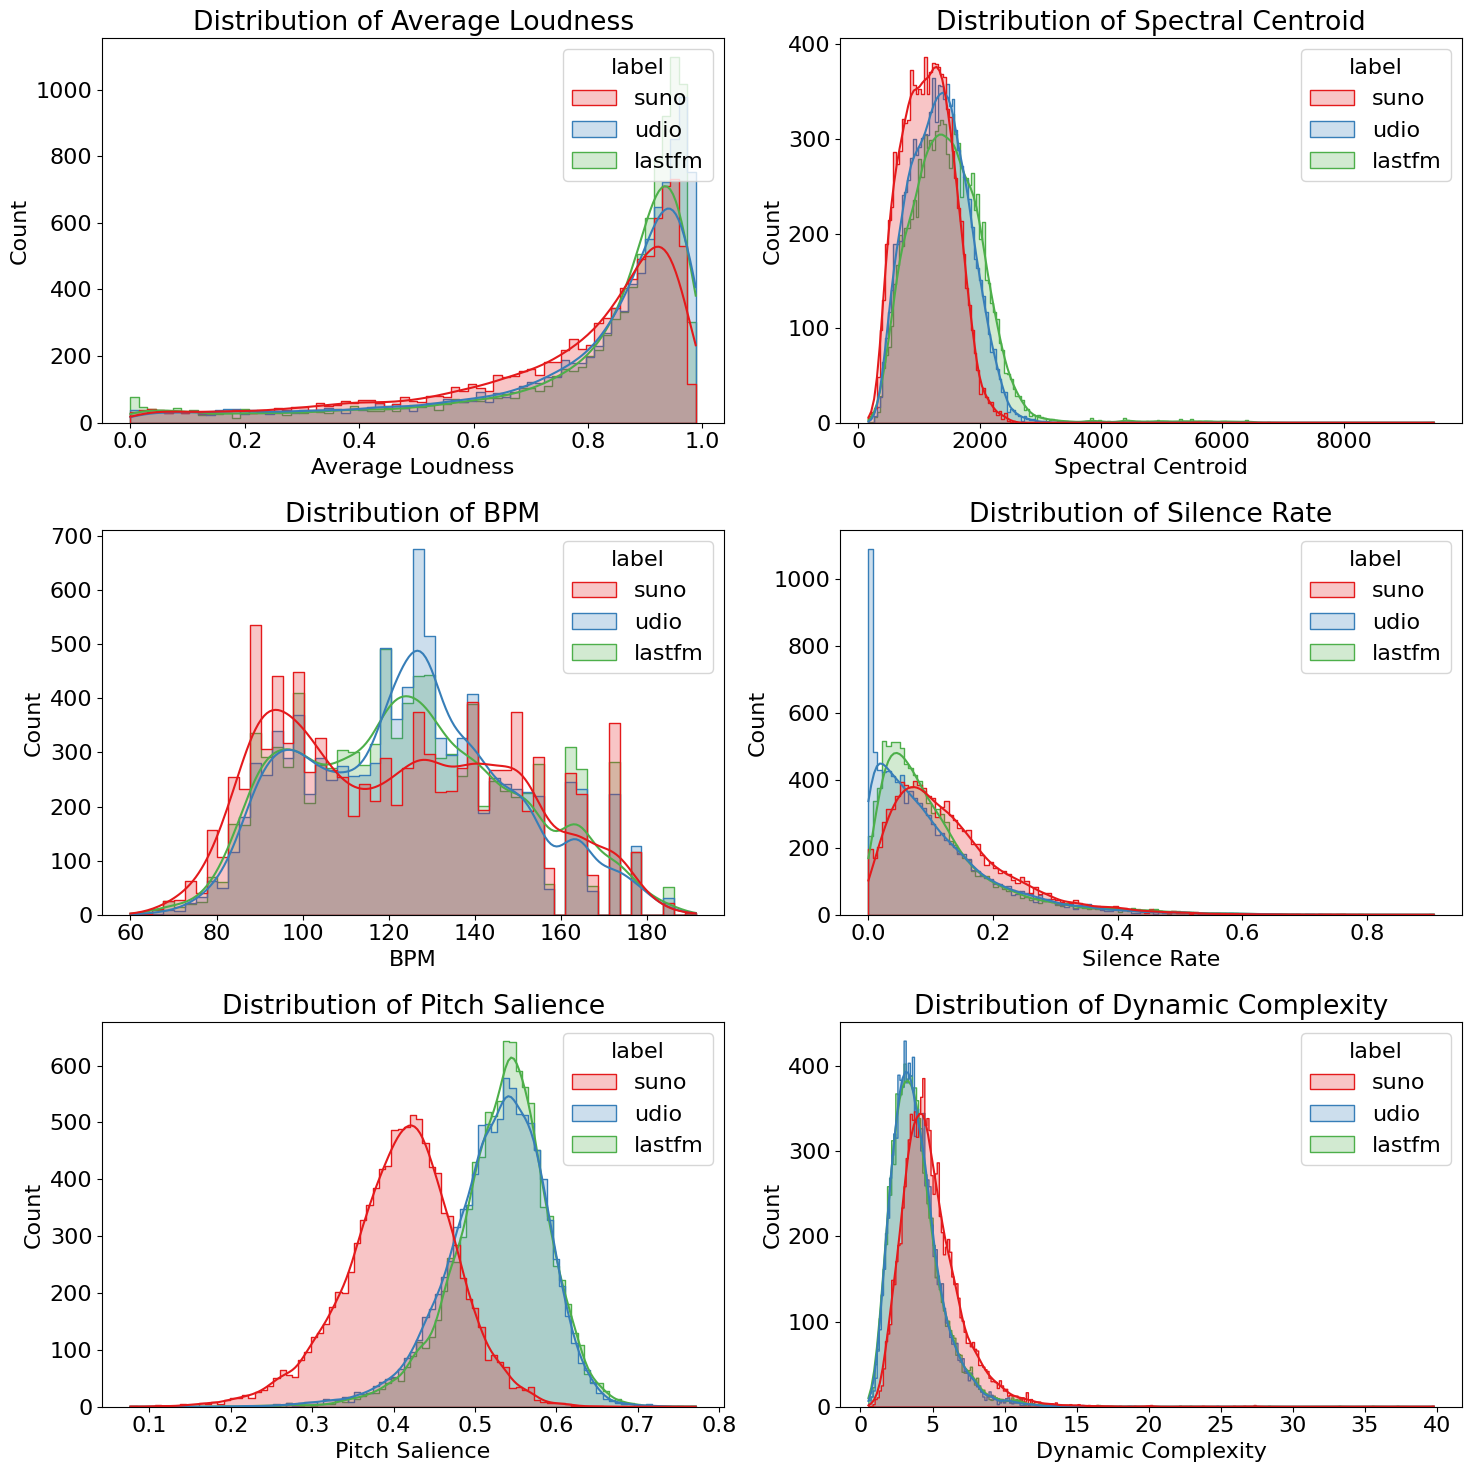

In [7]:
# plot the features_to_plot in a 3x2 grid, with a more old-fashioned style
def plot_feature_distributions(features_df, labels_df, features_to_plot, save=False):
    # Add the label to the features DataFrame
    features_df['label'] = labels_df

    # change features_df and features_to_plot to make them more readable
    features_df = features_df.rename(columns={'lowlevel.average_loudness': 'Average Loudness', 'lowlevel.spectral_centroid.mean': 'Spectral Centroid', 'rhythm.bpm': 'BPM', 'lowlevel.silence_rate_60dB.mean': 'Silence Rate', 'lowlevel.pitch_salience.mean': 'Pitch Salience', 'lowlevel.dynamic_complexity': 'Dynamic Complexity'})
    features_to_plot = ['Average Loudness', 'Spectral Centroid', 'BPM', 'Silence Rate', 'Pitch Salience', 'Dynamic Complexity']

    # Set up the plotting environment
    plt.figure(figsize=(15, 15))
    # big letters
    plt.rcParams.update({'font.size': 16})
    
    for i, feature in enumerate(features_to_plot):
        plt.subplot(3, 2, i + 1)
        sns.histplot(data=features_df, x=feature, hue='label', kde=True, element='step', palette='Set1')
        plt.title(f'Distribution of {feature}')
    
    plt.tight_layout()
    if save:
        #save as pdf
        plt.savefig('feature_distributions.pdf')
    plt.show()


plot_feature_distributions(df_features, df_labels, features_to_plot, save=True)

In [9]:
# save the df_features and df_labels as csv files
df_features.to_csv('/home/laura/aimir/mess/essentia_features.csv', index=False)
df_labels.to_csv('/home/laura/aimir/mess/essentia_labels.csv', index=False)

In [18]:
# perform an analysis on only the mfcc features
mfcc_features = df_features.filter(regex='lowlevel.mfcc.mean')
X_train, X_test, y_train, y_test = train_test_split(mfcc_features, df_labels, test_size=0.2, random_state=42, stratify=df_labels)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Get feature importance
feature_importance = pd.Series(clf.feature_importances_, index=mfcc_features.columns)
important_features = feature_importance.sort_values(ascending=False)

# plot the samples with only the top 2 features in a scatter plot
def plot_feature_scatter(features_df, labels_df, important_features, top_n=2):
    if isinstance(important_features, list):
        top_features = important_features[:top_n]
    else:
        top_features = important_features.head(top_n).index.tolist()
    
    # Add the label to the features DataFrame
    features_df['label'] = labels_df
    
    # Set up the plotting environment
    plt.figure(figsize=(10, 10))
    
    sns.scatterplot(data=features_df, x=top_features[0], y=top_features[1], hue='label', palette='Set1')
    plt.title(f'Scatter plot of {top_features[0]} vs {top_features[1]}')
    
    plt.tight_layout()
    plt.show()

plot_feature_scatter(mfcc_features, df_labels, important_features, top_n=2)


ValueError: Found input variables with inconsistent numbers of samples: [29996, 29997]